[0, 1, 2, 3, 4, 5, 6, 7, 8]
[(8, 36), (7, 41), (6, 54), (5, 8), (5, 13), (5, 14), (5, 22), (5, 23), (5, 24), (5, 29), (5, 31), (5, 38), (5, 51), (5, 62), (4, 11), (4, 12), (4, 15), (4, 27), (4, 42), (4, 44), (4, 58), (4, 60), (4, 65), (3, 0), (3, 4), (3, 5), (3, 6), (3, 17), (3, 19), (3, 21), (3, 25), (3, 26), (3, 28), (3, 45), (3, 53), (3, 56), (3, 59), (3, 66), (3, 67), (3, 69), (2, 1), (2, 2), (2, 3), (2, 9), (2, 10), (2, 18), (2, 30), (2, 33), (2, 34), (2, 35), (2, 37), (2, 39), (2, 43), (2, 46), (2, 47), (2, 48), (2, 55), (2, 57), (2, 63), (2, 68), (1, 7), (1, 16), (1, 20), (1, 40), (1, 49), (1, 52), (1, 61), (0, 32), (0, 50), (0, 64)]
[36, 41, 54, 8, 13, 14, 22, 23, 24, 29, 31, 38, 51, 62, 11, 12, 15, 27, 42, 44]
Seed: [34]   max: 25.5938
[36]
OVER
Seed: [34, 41]   max: 34.1658
[36, 41]
OVER
Seed: [34, 41, 31]   max: 38.9154
[36, 41, 54]
OVER
Seed: [34, 41, 31, 8]   max: 42.5632
[36, 41, 54, 8]
OVER
Seed: [34, 41, 31, 8, 24]   max: 45.3166
[36, 41, 54, 8, 13]
OVER
Seed: [34, 41, 

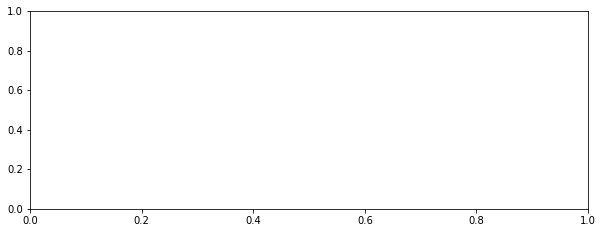

In [2]:
import matplotlib.pyplot as plt
from igraph import *
import networkx as nx
from random import uniform, seed
import numpy as np
import pandas as pd
import time
#class touch:

def IC(graph_object,S,p,mc):
    """
    Inputs: graph_object: 4 possible network representations 
                - igraph object
                - Networkx object
                - E x 2 Pandas dataframe of directed edges. Columns: ['source','target']
                - dictionary with key=source node & values=out-neighbors
            S:  List of seed nodes
            p:  Disease propagation probability
            mc: Number of Monte-Carlo simulations,
    Output: Average number of nodes influenced by seed nodes in S
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:
                       
            # 1. Find out-neighbors for each newly active node
            #if isinstance(graph_object, Graph):
            #    targets = propagate_ig(graph_object,p,new_active)
            if isinstance(graph_object, nx.DiGraph):
                targets = propagate_nx(graph_object,p,new_active)
            #elif isinstance(graph_object, dict):
            #    targets = propagate_dict(graph_object,p,new_active)
            #elif isinstance(graph_object, pd.DataFrame):
            #    targets = propagate_df(graph_object,p,new_active)
    
            # 2. Determine newly activated neighbors (set seed and sort for consistency)
            np.random.seed(i)
            success = np.random.uniform(0,1,len(targets)) < p
            new_ones = list(np.extract(success, sorted(targets)))
            #print(new_ones)
            # 3. Find newly activated nodes and add to the set of activated nodes
            new_active = list(set(new_ones) - set(A))
            A += list(set(new_active))
            
        
        #print('R=',i,'->',len(A))
        spread.append(len(A))
        
    return(np.mean(spread),A);
def PIC(graph_object,S,p,mc):
    """
    Inputs: graph_object: 4 possible network representations 
                - igraph object
                - Networkx object
                - E x 2 Pandas dataframe of directed edges. Columns: ['source','target']
                - dictionary with key=source node & values=out-neighbors
            S:  List of seed nodes
            p:  Disease propagation probability
            mc: Number of Monte-Carlo simulations,
    Output: Average number of nodes influenced by seed nodes in S
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    
    for i in range(mc):
        k=0;
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        
        touched={}
        nodes_still_active=[]
        while len(new_active)+len(nodes_still_active):
            targets=[]           
            # 1. Find out-neighbors for each newly active node
            nodes_still_active=[]
            #if isinstance(graph_object, Graph):
            #    targets = propagate_ig(graph_object,p,new_active,S)
            if isinstance(graph_object, nx.DiGraph):
                targets ,nodes_still_active= propagate_pic_nx(graph_object,p,new_active,S,touched,A)
            #print('targets:',targets);
            # 2. Determine newly activated neighbors (set seed and sort for consistency)
            np.random.seed(i)
            success = np.random.uniform(0,1,len(targets)) < p
            
            new_ones = list(np.extract(success, sorted(targets)));
            #print('new ones:',new_ones)
            new_active=nodes_still_active;
            # 3. Find newly activated nodes and add to the set of activated nodes
            new_active.extend(list(set(new_ones) - set(A)))
            #print("Length of new_active:",len(new_active))
            #for d in touched.keys():
            #    print(d,":",touched[d])
            
            #if new_active:
            #    print("new_active--TimeStamp#",k,':',new_active,' for seed :',S,'; total active set:',sorted(A))
            A += new_active
            A=list(set(A))
            k=k+1;
            
        #print('R=',i,'Simulation Done\n');
        spread.append(len(A))
        
    return(np.mean(spread),A)
def propagate_nx(g,p,new_active):
    
    targets = []
    for node in new_active:
        targets += g.neighbors(node)

    return(targets)

def propagate_pic_nx(g,p,new_active,S,touched,A):
    targets = []
    #temp=[]
    peer={}
    nodes_still_active=[]
    for node in new_active:
        #print('Node:',node)
        temp=g.neighbors(node);
        #print(len(temp))
        #print('i:',temp)
        f=lambda x:x not in touched.get(node,[])
        peer[node] = list(filter(f,temp))
        #print('Peers:',peer[node])
        #print(touched.get(node,[])," till now ")
        #peer[node] = list(temp)
        if(len(peer.get(node,[]))!=0):
            touched_node=peer[node][math.floor(np.random.uniform(0,1)*len(peer[node]))];
            #print(touched_node)
            targets.append(touched_node)
            p=[];
            #nodes_still_active.append(touched_node);
            p=touched.get(node,[])
            p.append(touched_node);
            touched[node]=p;
            
        #print(touched.get(node,[])," after now ")
        #print("Node #",node,' neighbourhood count = ',len(list(g.neighbors(node))))
        if(len(touched.get(node,[]))!=len(list(g.neighbors(node)))):
            nodes_still_active.append(node)
            #print("comparing ", len(touched.get(node,[])), ",",len(list(g.neighbors(node)))," for node ",node)
        #if(len(touched.get(node,[]))==len(list(g.neighbors(node)))):
            #print("Journey of ",node," ended")
    #for node  in list(set(new_active)-set(S)):
    
    #    if peer[node]:
    #        print('node#',node,'not in seed set trying to affect one of ',peer[node])
    return(targets,nodes_still_active)

def myFunc(e):
    return e[0];
def make_graph(nodes,edges):
    
    # Generate igraph object
    G = Graph.Erdos_Renyi(n=nodes,m=edges,directed=True)

    # Transform into NetworkX object
    g = nx.DiGraph(G.get_edgelist())


    return(G, g)

# Create Graphs
G, g = make_graph(12,120)

#for i in range(k):
#    b=False;
#    max_mean=0;
#    max_x=-1;
#    for x in g.nodes():
        
#        if x not in Seed:
#            b=True;
#            Seed.append(x);
#            mean,Active=PIC(g,Seed,p=0.3,mc=5000);
#            if mean>max_mean:
#                max_mean=mean;
#                max_x=x;
#            Seed.remove(x);
            #print("k: ",i," mean:",mean," x:",x);
#    if(b):        
#        Seed.append(max_x);
#print("Seed:",Seed,"  max:",max_mean);


# Choose arbitrary seed set
S = [1,8,4]

# Run algorithms
#output_nx, A_nx = IC(g,S,p=0.7,mc=2)

# Simulate the processes for different network sizes
e_size = [100,150,200,400]
ig_time, nx_time, df_time, di_time = [], [], [], []
output1igfig=[]
output1nxfig=[]
output1difig=[]
output1dffig=[]
e_size = [100,112,125,137,150,162,175,187,200,212,225,237,250,262,275,287,300,312,325,337,350,362,375,387,400,412,425,437,450,462,475,487,500,512,525,537,550,562,575,587,600,612,625,637,650,662,675,687,700,712,725,737,750,762,775,787,800]
S = [1,8,4]
ig_time, nx_time, df_time, di_time = [], [], [], []
output1igfig,output1nxfig,output1difig,output1dffig=[0],[0],[],[]
# for edges in e_size:
    
#     G, g = make_graph(50,edges)
#     print(edges);
    
#     start_time = time.time() 
#     output1ig,Aig = IC(g,S,p=0.5,mc=1000)
#     ig_time.append(time.time() - start_time)
#     output1igfig.append(output1ig);
#     start_time = time.time() 
#     output1nx,Anx = PIC(g,S,p=0.5,mc=1000)
#     nx_time.append(time.time() - start_time)
#     output1nxfig.append(output1nx);
#     start_time = time.time() 
# # Plot all methods
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(211)
# ax.plot(e_size, output1igfig, label="IC", color="#FBB4AE",lw=3)
# ax.plot(e_size, output1nxfig, label="PIC",color="#B3CDE3",lw=3)
# ax.legend(loc = 2)
# plt.ylabel('Number of Nodes spread')
# plt.xlabel('Network Size (Number of Edges)')
# plt.title('Computation Time')
# plt.tick_params(bottom = False, left = False)
# plt.show()

G, g=make_graph(70, 210)
seedSet_list=list(range(0, 70))
e_size=list(range(0,9))
print(e_size)
neighbors_list=[];
for i in range(70):
    neighbors_list.append((len(list(g.neighbors(i))),i));
neighbors_list.sort(key=myFunc,reverse = True)
print(neighbors_list)
seedsetListMax=[]
for i in range(20):
    seedsetListMax.append((neighbors_list[i])[1])
seedSet=[]
print(seedsetListMax);

Seed=[];
mean=0;
Active=[];
max_mean=0;
max_x=-1;
k=8;
while(len(seedSet)<20):


    myNode=math.floor(np.random.uniform(0,1)*len(seedSet_list));
    if (myNode not in seedSet):
        b=False;
        max_mean=0;
        max_x=-1;
        for x in g.nodes():
        
            if x not in Seed:
                b=True;
                Seed.append(x);
                mean,Active=PIC(g,Seed,p=0.5,mc=5000);
                if mean>max_mean:
                    max_mean=mean;
                    max_x=x;
                Seed.remove(x);
            #print("k: ",i," mean:",mean," x:",x);
        if(b):        
            Seed.append(max_x);
        print("Seed:",Seed,"  max:",max_mean);
        seedSet.append(myNode)
        #print(Seed)
        start_time=time.time()
        print(seedsetListMax[0:len(seedSet)])
        print("OVER")
        #output1ig,Aig= PIC(g, Seed , p=0.3, mc=5000)
        ig_time.append(time.time() - start_time)
        output1igfig.append(max_mean);
        start_time = time.time() 
        output1nx,Anx = PIC(g, seedsetListMax[0:len(seedSet)], p=0.5,mc=5000)
        nx_time.append(time.time() - start_time)
        output1nxfig.append(output1nx);
        start_time = time.time()

# print("done")  
# print(len(output1igfig))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(211)
#ax.plot(e_size, output1igfig, label="PIC_Greedy", color="#B3CDE3",lw=3)
#ax.plot(e_size, output1nxfig, label="PIC_Max_Degree",color="#FBB4AE",lw=3)
#ax.legend(loc = 2)
#plt.ylabel('Number of Nodes spread')
#plt.xlabel('Seed Set')
#plt.title('Computation Time')
#plt.tick_params(bottom = False, left = False)
#plt.show()

[0, 25.5938, 34.1658, 38.9154, 42.5632, 45.3166, 47.4844, 49.4308, 51.2604, 53.0052, 54.3024, 55.4724, 56.4154, 57.1818, 58.036, 58.73, 59.3416, 60.0252, 60.525, 61.0804, 61.5246]
[0, 24.3296, 34.8514, 38.7198, 41.4468, 43.7996, 45.2314, 47.074, 48.6622, 50.2576, 50.7886, 52.6832, 53.3228, 53.6756, 54.3878, 54.7262, 54.828, 55.0416, 55.0974, 55.3784, 55.7228]
21
21


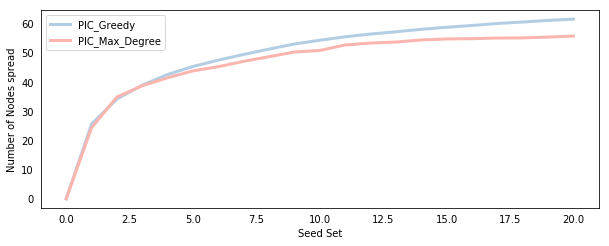

In [3]:

print(output1igfig);
print(output1nxfig);
print(len(output1igfig))
print(len(output1nxfig))
e_size1=list(range(0,21))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(211)
ax.plot(e_size1, output1igfig, label="PIC_Greedy", color="#B3CDE3",lw=3)
ax.plot(e_size1, output1nxfig, label="PIC_Max_Degree",color="#FBB4AE",lw=3)
ax.legend(loc = 2)
plt.ylabel('Number of Nodes spread')
plt.xlabel('Seed Set')
#plt.title('Computation Time')
plt.tick_params(bottom = False, left = False)
plt.show()